# Forecasting Bitcoin price with ARIMA model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = (12, 6)

In [153]:
start, train_size, test_size = 3800, 600, 85 # window on which we fit and test our model # 3800 600 85

data = pd.read_csv('data/bitcoin.csv', index_col=0)

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19,49.813290,51.835709,47.800831,49.982655,44871361,0,0.0
2004-08-20,50.316402,54.336334,50.062355,53.952770,22942874,0,0.0
2004-08-23,55.168217,56.528118,54.321388,54.495735,18342897,0,0.0
2004-08-24,55.412300,55.591629,51.591621,52.239197,15319808,0,0.0
2004-08-25,52.284027,53.798351,51.746044,52.802086,9232276,0,0.0
...,...,...,...,...,...,...,...
2022-06-13,2148.919922,2184.370117,2131.760986,2137.530029,1837800,0,0.0
2022-06-14,2137.800049,2169.149902,2127.040039,2143.879883,1274000,0,0.0
2022-06-15,2177.989990,2241.260010,2162.375000,2207.810059,1659600,0,0.0


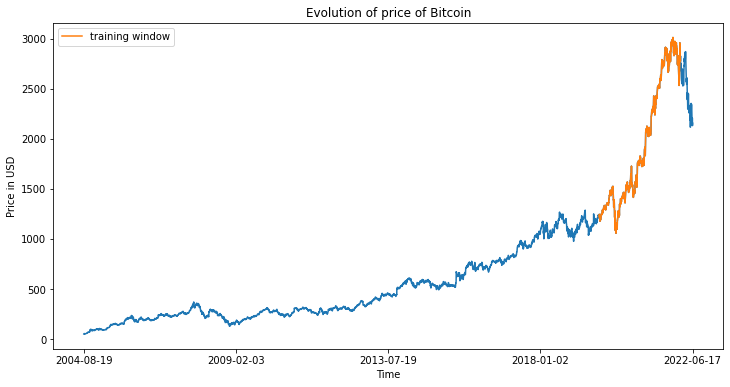

In [154]:
price = data['Close']

plt.plot(price)
plt.plot(price.iloc[start:start+train_size], label='training window')
plt.title('Evolution of price of Bitcoin')
plt.ylabel('Price in USD')
plt.xlabel('Time')
plt.legend()
plt.xticks([price.index[i*(len(price)-1)//4]for i in range(5)])
plt.show()


In [155]:
log_price = price.map(np.log)

log_price

Date
2004-08-19    3.911676
2004-08-20    3.988109
2004-08-23    3.998122
2004-08-24    3.955833
2004-08-25    3.966551
                ...   
2022-06-13    7.667406
2022-06-14    7.670372
2022-06-15    7.699756
2022-06-16    7.665153
2022-06-17    7.676617
Name: Close, Length: 4490, dtype: float64

In [156]:
# Making the data stationnary

log_p_train = log_price.iloc[start:start+train_size].to_numpy()

d = 0
while adfuller(np.diff(log_p_train, d))[1] >= 0.01: # we chose a p-value of 0.01
    d += 1

print('log-prices are I({}).'.format(d))

log-prices are I(1).


In [157]:
log_ret = pd.DataFrame({'log_ret': np.diff(log_price, 1)}, index=log_price.index[1:])

log_ret_train = log_ret.iloc[start:start+train_size]

log_ret_train

,log_ret
Date,
2019-09-25,0.022522
2019-09-26,-0.004124
2019-09-27,-0.013217
2019-09-30,-0.004983
2019-10-01,-0.011468
...,...
2022-02-03,-0.037061
2022-02-04,0.002559
2022-02-07,-0.028929


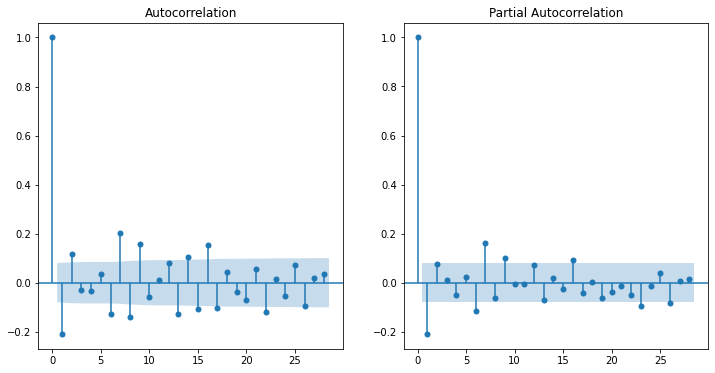

In [158]:
# plotting acf and pacf

fig, axs = plt.subplots(nrows=1, ncols=2)

sm.graphics.tsa.plot_acf(log_ret_train, ax=axs[0])
sm.graphics.tsa.plot_pacf(log_ret_train, ax=axs[1])

plt.show()

In [159]:
# fitting ARIMA

order_select = arma_order_select_ic(log_ret_train, max_ar=4, max_ma=4, ic='bic')

order_select

{'bic':              0            1            2            3            4
 0 -3018.631793 -3034.845307 -3035.818511 -3030.263872 -3024.028766
 1 -3039.085352 -3035.278711 -3030.052786 -3024.150277 -3017.794424
 2 -3036.124071 -3029.755842 -3056.171065 -3018.208881 -3014.415527
 3 -3029.792307 -3023.411193 -3023.576837 -3046.391316 -3010.748015
 4 -3024.831755 -3030.236632 -3043.763106 -3037.382219 -3033.857391,
 'bic_min_order': (2, 2)}

In [160]:
acorr_ljungbox(log_ret_train)

(array([ 26.35553186,  34.482879  ,  34.9943153 ,  35.68586453,
         36.53353871,  46.50598127,  71.11569477,  83.17651423,
         98.03068212, 100.08838762, 100.16380772, 104.05757081,
        114.04846109, 120.65897271, 127.58726267, 142.34098851,
        148.9289251 , 150.04815082, 150.92882119, 153.97647863,
        155.80011778, 164.8356096 , 164.94308177, 166.71866746,
        169.91749321, 175.44311364, 175.71868756, 176.58427506,
        177.51945793, 177.70279054, 178.09544074, 178.87297349,
        183.20022212, 185.0885282 , 186.09692346, 186.13053347,
        186.41644338, 186.42020288, 186.61767195, 186.61782185]),
 array([2.84004323e-07, 3.25190586e-08, 1.22162333e-07, 3.35785133e-07,
        7.42765174e-07, 2.34743076e-08, 8.78845944e-13, 1.11917175e-14,
        3.93458681e-17, 5.23217809e-17, 1.65730849e-16, 8.89538933e-17,
        2.99905216e-18, 4.67442528e-19, 6.30290880e-20, 2.50592192e-22,
        3.96570574e-23, 7.27384969e-23, 1.45050896e-22, 1.08557911e-22

In [163]:
# Evaluating a model on out-of-sample data

best_model = ARIMA(log_ret_train, order=(2, 0, 2)).fit()

best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                log_ret   No. Observations:                  600
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1530.979
Date:                Fri, 24 Jun 2022   AIC                          -3049.959
Time:                        00:13:24   BIC                          -3023.577
Sample:                             0   HQIC                         -3039.689
                                - 600                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.957      0.050   -1.82e-06       0.003
ar.L1         -0.4992      1.437     -0.347      0.728      -3.316       2.317
ar.L2         -0.0699      0.722     -0.097      0.923      -1.484       1.345
ma.L1          0.3039      1.440      0.211      0.833      -2.519       3.126
ma.L2          0.0854      0.445      0.192      0.848      -0.787       0.958
sigma2         0.0004   1.25e-05     28.501      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               491.75
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

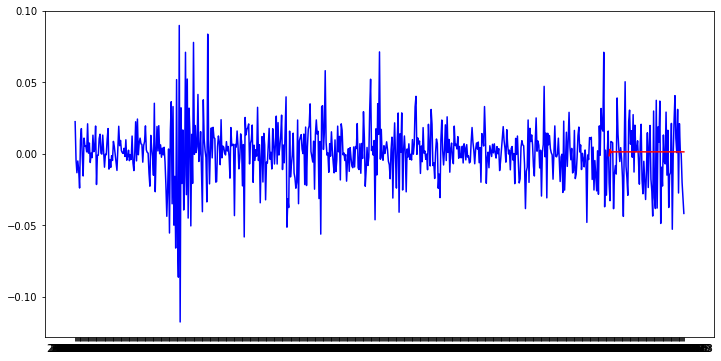

In [164]:
log_ret_pred = best_model.forecast(test_size)

plt.plot(log_ret.iloc[start:start+train_size+test_size], color='blue')
plt.plot(log_ret.iloc[start+train_size:start+train_size+test_size].index, log_ret_pred, color='red')
plt.show()

## Biblio

https://arxiv.org/pdf/1904.05315.pdf
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8566476
https://books.google.fr/books?hl=fr&lr=&id=671dDwAAQBAJ&oi=fnd&pg=PA171&dq=ARIMA+bitcoin&ots=xKGdfBeQMf&sig=u8lfL_yi7BexZtvlFRXmE2pxMeM&redir_esc=y#v=onepage&q=ARIMA%20bitcoin&f=false
https://ieeexplore.ieee.org/abstract/document/8374483?casa_token=8ikJY0BaAg4AAAAA:wlMUuRELtPK6vkkULQdThDYT-obu49QSPgq-PNuMzMHyTXXLVZiY_yjSmsgn_iN43ynbGtp4Ky1V

## Remarques

On peut utiliser :
- un modèle ARIMA (modèle plus simple que les deux prochains, plus facile à expliquer, plus rapide)
- un RNN LSTM (doit superformer ARIMA, surtout pour des prédictions sur des temps longs)
- Prophet (doit surperformer ARIMA également)

On peut ajouter des features (tweets en rapport avec le bitcoin, prix d'autres cryptomonnaies, volumes, etc.) => multivariate time-series forecasting 
On peut prendre un dataset avec les prix à la minute.